In [1]:
from simtk.openmm import app, LangevinIntegrator, XmlSerializer
from simtk import unit
from openforcefield.typing.engines.smirnoff import ForceField as OFFForceField
from openforcefield.topology import Molecule as OFFMolecule
from openforcefield.topology import Topology as OFFTopology
from openforcefield.topology import TopologyAtom
import numpy as np

_ColormakerRegistry()

## Part 1: Fun with VirtualSites. Define a twofold sulfur lone pair virtual site and run a short simulation
(There is a known bug where you can only load a vsite OFFXML once per python session -- So restart the kernel if you modify the OFFXML!)

In [2]:
sulfur_vsite_offxml = '''<?xml version="1.0" encoding="utf-8"?>
<SMIRNOFF version="0.3" aromaticity_model="OEAroModel_MDL">
    <VirtualSites version="0.3">
        <VirtualSite
            type="DivalentLonePair"
            name="EP"
            smirks="[*:1]-[#16X2:2]-[*:3]"
            distance="0.70 * angstrom"
            chargeincrement1="0.1205*elementary_charge"
            chargeincrement2="0.0*elementary_charge"
            chargeincrement3="0.1205*elementary_charge"
            sigma="0.1*angstrom"
            epsilon="0.0*kilocalories_per_mole"
            outOfPlaneAngle="54.71384225*degree"
            inPlaneAngle="0*degree"
            orientation="0,1" >
        </VirtualSite>
    <VirtualSite 
			type="BondCharge"
			name="EP"
			smirks="[*:1][Cl:2]"
			distance="0.3*angstrom"
			chargeincrement1="0.3*elementary_charge"
			chargeincrement2="0.0*elementary_charge"
			sigma="0.1*angstrom"
			epsilon="0.05*kilocalories_per_mole"
			orientation="0" >
		</VirtualSite>
    	<VirtualSite 
			type="BondCharge"
			name="EP"
			smirks="[*:1][Br:2]"
			distance="0.8*angstrom"
			chargeincrement1="0.4*elementary_charge"
			chargeincrement2="0.0*elementary_charge"
			sigma="0.1*angstrom"
			epsilon="0.05*kilocalories_per_mole"
			orientation="0" >
		</VirtualSite>
    </VirtualSites>
</SMIRNOFF>
'''
ff = OFFForceField('openff-1.2.0.offxml', sulfur_vsite_offxml)

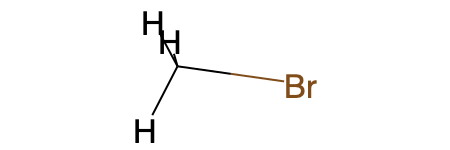

In [5]:
#offmol = OFFMolecule.from_smiles('c1cc(-Cl)ccc1C(=O)CSC1COC(Br)CC1')
offmol = OFFMolecule.from_smiles('CBr')

offmol.generate_conformers(n_conformers=1)
offmol.visualize()

In [6]:
# Make the OpenMM system and grab the resulting Topology (with VSites added)

off_top = offmol.to_topology()
off_sys, off_top_w_vsites = ff.create_openmm_system(offmol.to_topology(), return_topology=True)

In [7]:
# Retrieve the number of virtualsites that were added
n_virtual_sites = off_top_w_vsites.n_topology_particles - off_top_w_vsites.n_topology_atoms

# Get an OpenMM Topology from our openFF Topology
omm_top = off_top.to_openmm()

# to_openmm doesn't handle virtualsites yet, so we add them manually to the openmm topology here
for top_particle in off_top_w_vsites.topology_particles:
    if isinstance(top_particle, TopologyAtom):
        continue
    print(top_particle.virtual_site.name, app.Element.getByMass(0), [i for i in omm_top.residues()][0])
    omm_top.addAtom(top_particle.virtual_site.name, app.Element.getByMass(0), [i for i in omm_top.residues()][0])

EP None <Residue 0 () of chain 0>


In [8]:
from simtk import openmm, unit

# Propagate the System with Langevin dynamics.
time_step = 2*unit.femtoseconds  # simulation timestep
temperature = 300*unit.kelvin  # simulation temperature
friction = 1/unit.picosecond  # collision rate
integrator = openmm.LangevinIntegrator(temperature, friction, time_step)

# Length of the simulation.
num_steps = 1000  # number of integration steps to run

# Logging options.
trj_freq = 1  # number of steps per written trajectory frame
data_freq = 1  # number of steps per written simulation statistics

# Set up an OpenMM simulation.
simulation = openmm.app.Simulation(omm_top, off_sys, integrator)

# Set the initial positions.
positions = np.concatenate((offmol.conformers[0], np.zeros((n_virtual_sites, 3))), 
                           axis=0) * unit.angstrom
simulation.context.setPositions(positions)

# Randomize the velocities from a Boltzmann distribution at a given temperature.
simulation.context.setVelocitiesToTemperature(temperature)

# Configure the information in the output files.
pdb_reporter = openmm.app.PDBReporter('trajectory.pdb', trj_freq)
state_data_reporter = openmm.app.StateDataReporter('data.csv', data_freq, step=True,
                                                   potentialEnergy=True, temperature=True,
                                                   density=True)
simulation.reporters.append(pdb_reporter)
simulation.reporters.append(state_data_reporter)

In [9]:
import time

print("Starting simulation")
start = time.process_time()

# Run the simulation
simulation.step(num_steps)

end = time.process_time()
print("Elapsed time %.2f seconds" % (end-start))
print("Done!")


Starting simulation
Elapsed time 1.71 seconds
Done!


Now go visualize `trajectory.pdb` in VMD or PyMol!

## Part 2: Numerical comparison of OpenMM's TIP5P and an equivalent SMIRNOFF implementation 

Parameterizes a water box with OpenFF and OpenMM forcefields. Currently set up
to use a TIP5P definition. The code examines the geometry and energy between the
two, and examines cases where minimization is performed. Specifically, the code
compares the four possible combinations:
    - oFF and oMM geometry/energy, minimized separately and then compared
    - oFF and oMM geometry/energy using no minimization
    - Geometry minimized using oFF, then a single point is done with oMM
    - Geometry minimized using oMM, then a single point is done with oFF

The virtual site definitions give differences in geometry and energy mostly due
to how their were defined from their parent atoms. OpenMM uses a OutOfPlaneSite
definition, whereas OpenFF uses the LocalCoordinatesSite definition (both are
OpenMM types). In the OutOfPlaneSite definition, both angle and distance is
variable since the defined out-of-plane angle depends on a weighted vector cross.
The cross is a function of the O-H vectors, so the virtual sites are sensitive
to the molecular geometry. In the OpenFF spec the distance is fixed to a constant
value, and the out-of-plane angle is explicitly required in the OpenFF spec.

In this example, the OpenFF parameter definition (the "offxml") is a string
further below in the `main` function, and can be easily modified to explore
forcefield parameterization. The OpenMM definition is loaded from its internal 
default location, and acts as a reference. One can change this this to a different
filename to compare other forcefields.

The code is somewhat hardcode to operate on water molecules, but can be easily
modified to examine other cases as well. The only major assumption is that the
system is homogenous, i.e., all of the molecules are same. This is mostly due to
the difference in how virtual sites are handled between OpenFF and OpenMM.
Whereas OpenMM interleaves the virtual site particles between the atomic
particles, OpenFF instead aggregates all virtual sites and places them last. The
code below does assume that, barring this difference, the virtual sites are
added in the same order.

The example begins in `run_tests` by defining a grid of water molecules, with
the default being a single water (Nx=1, Ny=1, Nz=1). From this, the calculations
described in the first paragraph above are performed. The energy difference and
distance between the two geometries, per atom, is then reported. There are
commented lines that print the entire set of coordinates, and can be uncommented
if desired.


The following functions are utilities and other infrastructure to make  comparison between OpenFF and OpenMM calculations easier.


In [8]:

# To get a fair comparison , take the OpenMM virtual sites and put them at the
# end so that they follow the same order as the oFF order.
def reorder_openmm_to_openff(xyz, n_atoms_per_mol, n_vsites_per_mol):
    """
    """
    # constants for simplicity
    n_particles_per_mol = (n_atoms_per_mol + n_vsites_per_mol)
    n_mols = xyz.shape[0] // n_particles_per_mol

    atom_base_indices = np.arange(n_atoms_per_mol)
    atom_indices = np.hstack([atom_base_indices + (i*n_particles_per_mol) for i in range(n_mols)])

    vsite_base_indices = np.arange(n_vsites_per_mol) + n_atoms_per_mol 
    vsite_indices = np.hstack([vsite_base_indices + (i*n_particles_per_mol) for i in range(n_mols)])

    mask = np.hstack([atom_indices, vsite_indices])

    return xyz[mask]

In [9]:


def reorder_openff_to_openmm(xyz, n_atoms_per_mol, n_vsites_per_mol):
    # constants for simplicity
    n_particles_per_mol = (n_atoms_per_mol + n_vsites_per_mol)
    n_mols = xyz.shape[0] // n_particles_per_mol

    atom_base_indices = np.arange(n_atoms_per_mol)
    vsite_base_indices = np.arange(n_vsites_per_mol) + n_atoms_per_mol * n_mols

    mask = np.hstack([
        np.hstack([atom_base_indices + (i*n_atoms_per_mol), vsite_base_indices + (i*n_vsites_per_mol)]) for i in range(n_mols)])

    return xyz[mask]

In [10]:


def openmm_evaluate_vsites_and_energy(omm_top,
                                      omm_sys,
                                      atom_xyz_in_nm,
                                      minimize=False):
    """
    Calculate the Virtual Site positions and potential energy
    of the given system

    Parameters
    ----------
    omm_top: OpenMM Topology
    omm_sys: OpenMM System
    atom_xyz_in_nm: N,3 List of floats interpreted as nanometers
    minimize: Boolean Perform a minimization before calculating energy

    Returns
    -------
    pos: N,3 List of floats of the positions of all particles
    ene: The potential energy of the particle positions
    """

    integ = LangevinIntegrator(300 * unit.kelvin, 1 / unit.picosecond,
                               0.002 * unit.picoseconds)

    sim = app.Simulation(omm_top, omm_sys, integ)
    pos = sim.context.getState(getPositions=True).getPositions()


    sim.context.setPositions(atom_xyz_in_nm)

    # Once the atom positions are known, virtual sites can
    # be determined.
    sim.context.computeVirtualSites()


    if minimize:
        sim.minimizeEnergy()

    state = sim.context.getState(getEnergy=True, getPositions=True)
    ene = state.getPotentialEnergy()
    pos = [
        list(xyz) for xyz in state.getPositions().value_in_unit(unit.nanometer)
    ] * unit.nanometer
    return pos, ene

In [11]:

def build_openff_water_lattice(Nx=1, Ny=1, Nz=1, dx=2.0, dy=2.0, dz=2.0):
    """
    Generate a box of water molecules as OpenFF Molecules

    Parameters
    ----------
        Nx, Ny, Nz: The number of molecules in each directon
        dx, dy, dz: The spacing between the molecules in each direction

    Returns
    -------
        water_box: A List of OpenFF molecules with a 3D conformation
    """
    Lx, Ly, Lz = Nx * dx, Ny * dy, Nz * dz
    Z, Y, X = np.mgrid[0:Lz:dz, 0:Ly:dy, 0:Lx:dx]
    XYZ = [list(xyz) for xyz in zip(X.flat, Y.flat, Z.flat)]

    water_box = list([None] * len(XYZ))

    water_reference = OFFMolecule.from_smiles('O')
    water_reference.atoms[0].name = 'O'
    water_reference.atoms[1].name = 'H1'
    water_reference.atoms[2].name = 'H2'
    water_reference.generate_conformers()

    for i, xyz in enumerate(XYZ):
        water_box[i] = OFFMolecule(water_reference)
        water_box[i].conformers[0] += xyz * unit.angstrom

    return water_box


In [12]:

def insert_vsite_padding(xyz, n_mol, n_vsite, order="OpenFF"):
    """
    Given a set of atomic coordinates, insert dummy coordinates in indices
    expected for either OpenFF or OpenMM. OpenFF places the dummy coordinates
    at the end, whereas OpenMM expects virtual sites to be next to their owning
    molecule.
    Parameters
    ----------
        xyz: N,3 List, of coordinates of atoms only
        n_mol: int, The number of molecules
        n_vsite: int, The number of virtual site dummy positions to insert
    
    Returns
    -------
        xyz: (N+n_vsite,3) List, the coordinates of all particles in the
        expected order
    """

    # heuristic that vsites come at the end; applies to OpenFF
    vsite_pad = np.arange(n_vsite*3).reshape(n_vsite, 3)
    xyz = np.vstack([xyz, vsite_pad])

    # but does not apply to OpenMM. Need to interleave vsite coordinates
    if order == "OpenMM":
        n_vsites_per_mol = n_vsite // n_mol
        n_atoms_per_mol = len(xyz) // n_mol - n_vsites_per_mol
        xyz = reorder_openff_to_openmm(xyz, n_atoms_per_mol, n_vsites_per_mol)
    
    return xyz


In [13]:

def coords_from_off_mols(mols, conformer_id=0, unit=unit.angstrom):
    """
    Small utility to extract the coordinates from the molecule conformers,
    with optional unit conversion
    """
    xyz = np.vstack(
        [mol.conformers[conformer_id].value_in_unit(unit) for mol in mols])
    return xyz * unit


The function to calculate water using the oMM definition


In [14]:

def evaluate_water_omm(water, ff, minimize=False):
    """
    Given a list of molecules and a forcefield definition, calculate the
    positions and energy.
    
    Parameters
    ----------
        water: List of OFFMolecules, each with a 3D conformation
        ff: an OpenMM ForceField object
        minimize: Boolean, whether the structure should be minimized

    Returns
    -------
        xyz: List The coordinates of all particles in the system (OpenMM ordering)
        ene: float, The potential energy
    """

    top = OFFTopology.from_molecules(water).to_openmm()

    # get the oFF topology and the positions
    atom_xyz = coords_from_off_mols(water, unit=unit.nanometer)

    # first pass; no virtual sites
    omm_modeller = app.Modeller(top, atom_xyz)
    omm_modeller.addExtraParticles(ff)

    # second pass: virtual sites now present (according to oMM FF)
    top = omm_modeller.getTopology()


    sys = ff.createSystem(top, nonbondedMethod=app.NoCutoff)
    n_vsite = sys.getNumParticles() - len(atom_xyz) 
    n_mol = len(water)

    # need to insert dummy positions into coordinates, since OpenMM
    # systems create virtual site particles in place, i.e. OHHMMOHHMM etc.
    atom_xyz = insert_vsite_padding(atom_xyz, n_mol, n_vsite, order="OpenMM")

    # Need an openMM topology, an openMM system, and a set of positions
    # to calculate the energy. Also returns the vsite positions based
    # on supplied atom coordinates
    xyz, ene = openmm_evaluate_vsites_and_energy(top, sys, atom_xyz, minimize=minimize)

    return xyz,ene

The function to calculate water using the oFF definition


In [15]:
def evaluate_water_off(water, ff, minimize=False):
    """
    Given a list of molecules and a forcefield definition, calculate the
    positions and energy.
    
    Parameters
    ----------
        water: List of OFFMolecules, each with a 3D conformation
        ff: an OpenFF ForceField object
        minimize: Boolean, whether the structure should be minimized

    Returns
    -------
        xyz: List The coordinates of all particles in the system (OpenMM ordering)
        ene: float, The potential energy
    """

    # get the oFF topology and the positions
    top = OFFTopology.from_molecules(water)
    atom_xyz = coords_from_off_mols(water, unit=unit.nanometer)

    # IMPORTANT! The new system has the virtual sites, but the oFF top does not as there is no API yet to do so
    sys = ff.create_openmm_system(top)

    n_vsite = sys.getNumParticles() - len(atom_xyz) 
    n_mol = len(water)
    atom_xyz = insert_vsite_padding(atom_xyz, n_mol, n_vsite, order="OpenFF")

    # Need an openMM topology, an openMM system, and a set of positions
    # to calculate the energy. Also returns the vsite positions based
    # on supplied atom coordinates
    xyz, ene = openmm_evaluate_vsites_and_energy(top.to_openmm(), sys, atom_xyz, minimize=minimize)

    return xyz,ene


In [16]:

def print_info(xyz, ene, name):
    """
    """
    print("####")
    print(f"RESULTS FOR {name}")
    print(f"ENERGY: {ene}")
    print("COORDINATES:")
    print(xyz)
    print()


In [17]:
tip5p_offxml = '''<?xml version="1.0" encoding="utf-8"?>
<SMIRNOFF version="0.3" aromaticity_model="OEAroModel_MDL">
    <LibraryCharges version="0.3">
            <LibraryCharge name="tip5p" smirks="[#1:1]-[#8X2H2+0:2]-[#1:3]" charge1="0.*elementary_charge" charge2="0.*elementary_charge" charge3="0.*elementary_charge"/>
    </LibraryCharges>
    <vdW version="0.3" potential="Lennard-Jones-12-6" combining_rules="Lorentz-Berthelot" scale12="0.0" scale13="0.0" scale14="0.5" scale15="1.0" switch_width="1.0 * angstrom" cutoff="9.0 * angstrom" method="cutoff">
            <Atom smirks="[#1:1]-[#8X2H2+0]-[#1]" epsilon="0. * mole**-1 * kilojoule" id="n35" sigma="1 * nanometer"/>
            <Atom smirks="[#1]-[#8X2H2+0:1]-[#1]" epsilon="0.66944 * mole**-1 * kilojoule" id="n35" sigma="0.312 * nanometer"/>
    </vdW>
     <Bonds version="0.3" potential="harmonic" fractional_bondorder_method="None" fractional_bondorder_interpolation="linear">
        <Bond smirks="[#1:1]-[#8X2H2+0:2]-[#1]" length="0.9572 * angstrom" k="462750.4 * nanometer**-2 * mole**-1 * kilojoule" id="b1" />   
    </Bonds>
    <Angles version="0.3" potential="harmonic">
        <Angle smirks="[#1:1]-[#8X2H2+0:2]-[#1:3]" angle="1.82421813418 * radian" k="836.8 * mole**-1 * radian**-2 * kilojoule" id="a1" />
    </Angles>
    <VirtualSites version="0.3">
        <VirtualSite
            type="DivalentLonePair"
            name="EP"
            smirks="[#1:1]-[#8X2H2+0:2]-[#1:3]"
            distance="0.70 * angstrom"
            chargeincrement1="0.1205*elementary_charge"
            chargeincrement2="0.0*elementary_charge"
            chargeincrement3="0.1205*elementary_charge"
            sigma="0.1*angstrom"
            epsilon="0.0*kilocalories_per_mole"
            outOfPlaneAngle="54.71384225*degree"
            inPlaneAngle="0*degree"
            orientation="0,1" >
        </VirtualSite>
    </VirtualSites>
    <Electrostatics version="0.3" method="PME" scale12="0.0" scale13="0.0" scale14="0.833333" scale15="1.0" switch_width="0.0 * angstrom" cutoff="9.0 * angstrom"/>
</SMIRNOFF>
'''

constraints = """
  <Constraints version="0.3">
    <Constraint smirks="[#1:1]-[#8X2H2+0:2]-[#1]" id="c1" distance="0.9572 * angstrom"/>
    <Constraint smirks="[#1:1]-[#8X2H2+0]-[#1:2]" id="c2" distance="1.5139006545247014 * angstrom"/>
  </Constraints>
"""

In [18]:
# Our custom-crafted oFF force field definition above

# Evaluate these here only once. Important for OFF, since the second time
# always seems to fail inside xmltodict parsing

off_ff = OFFForceField(tip5p_offxml)

# The standard OpenMM definition of tip5p
omm_ff = app.ForceField('tip5p.xml')


SMIRNOFFSpecError: Unexpected kwarg (VirtualSite: OrderedDict([('type', 'DivalentLonePair'), ('name', 'EP'), ('smirks', '[#1:1]-[#8X2H2+0:2]-[#1:3]'), ('distance', Quantity(value=0.7, unit=angstrom)), ('chargeincrement1', Quantity(value=0.1205, unit=elementary charge)), ('chargeincrement2', Quantity(value=0.0, unit=elementary charge)), ('chargeincrement3', Quantity(value=0.1205, unit=elementary charge)), ('sigma', Quantity(value=0.1, unit=angstrom)), ('epsilon', Quantity(value=0.0, unit=kilocalorie/mole)), ('outOfPlaneAngle', Quantity(value=54.71384225, unit=degree)), ('inPlaneAngle', Quantity(value=0, unit=degree)), ('orientation', '0,1')]))  passed to <class 'openforcefield.typing.engines.smirnoff.parameters.VirtualSiteHandler'> constructor. If this is a desired cosmetic attribute, consider setting 'allow_cosmetic_attributes=True'

In [ ]:

minimize=True


Nx, Ny, Nz = (1,1,1) # 2x2x2 = 8 water molecules
dx, dy, dz = (3,3,3) # water spaced 3A apart in each direction

#Nx, Ny, Nz = (1,1,1) 

gridspec = [Nx,Ny,Nz,dx,dy,dz]

n_atoms_per_mol = 3
n_vsites_per_mol = 2
np.set_printoptions(formatter={'float_kind': "{:9.10f}".format})

if True:
    minimize=True
    print("===> EVALUATE SEPARATE OFF AND OMM MINIMIZATIONS <===")

    # default spacing of water is 2 Angstroms (dx,dy,dz arguments)
    water_box = build_openff_water_lattice(*gridspec)

    off_crds, off_ene = evaluate_water_off(water_box, off_ff, minimize=minimize)
    off_crds = np.array(off_crds.value_in_unit(unit.angstrom))

    omm_crds, omm_ene = evaluate_water_omm(water_box, omm_ff, minimize=minimize)
    omm_crds = np.array(omm_crds.value_in_unit(unit.angstrom))

    # constants for ordering (to compare positions)
    # We assume here that system is homogenous for the reordering
    omm_crds = reorder_openmm_to_openff(omm_crds, n_atoms_per_mol, n_vsites_per_mol)

    # print_info(off_crds, off_ene, "OpenForceField")
    # print_info(omm_crds, omm_ene, "OpenMM")
    # print_info(off_crds - omm_crds, off_ene - omm_ene, "OFF - OMM")
    print_info(np.linalg.norm(off_crds - omm_crds, axis=1), off_ene - omm_ene, "OFF - OMM norm")

if True:
    minimize=False
    print("===> EVALUATE OFF AND OMM NO MINIMIZATION SINGLE POINT <===")

    # default spacing of water is 2 Angstroms (dx,dy,dz arguments)
    water_box = build_openff_water_lattice(*gridspec)

    off_crds, off_ene = evaluate_water_off(water_box, off_ff, minimize=minimize)
    off_crds = np.array(off_crds.value_in_unit(unit.angstrom))

    omm_crds, omm_ene = evaluate_water_omm(water_box, omm_ff, minimize=minimize)
    omm_crds = np.array(omm_crds.value_in_unit(unit.angstrom))

    # constants for ordering (to compare positions)
    # We assume here that system is homogenous for the reordering
    omm_crds = reorder_openmm_to_openff(omm_crds, n_atoms_per_mol, n_vsites_per_mol)

    # print_info(off_crds, off_ene, "OpenForceField")
    # print_info(omm_crds, omm_ene, "OpenMM")
    # print_info(off_crds - omm_crds, off_ene - omm_ene, "OFF - OMM")
    print_info(np.linalg.norm(off_crds - omm_crds, axis=1), off_ene - omm_ene, "OFF - OMM norm")

if True:
    print("===> EVALUATE OMM MINUMUM WITH OFF SINGLE POINT <===")
    water_box = build_openff_water_lattice(*gridspec)
    omm_crds, omm_ene = evaluate_water_omm(water_box, omm_ff, minimize=True)
    omm_crds = np.array(omm_crds.value_in_unit(unit.angstrom))

    # Need some machinery here to copy the minimized coordinates into the next single
    # point calculation
    omm_crds = reorder_openmm_to_openff(omm_crds, n_atoms_per_mol, n_vsites_per_mol)
    for i,mol in enumerate(water_box):
        pos = omm_crds[3*i:3*i + 3]
        mol.conformers[0][:] = pos * unit.angstrom

    off_crds, off_ene = evaluate_water_off(water_box, off_ff, minimize=False)
    off_crds = np.array(off_crds.value_in_unit(unit.angstrom))

    # print_info(omm_crds, omm_ene, "OpenMM")
    # print_info(off_crds, off_ene, "OpenForceField")
    # print_info(off_crds - omm_crds, off_ene - omm_ene, "OFF - OMM")
    print_info(np.linalg.norm(off_crds - omm_crds, axis=1), off_ene - omm_ene, "OFF - OMM norm")

if True:
    print("===> EVALUATE OFF MINUMUM WITH OMM SINGLE POINT <===")
    water_box = build_openff_water_lattice(*gridspec)
    off_crds, off_ene = evaluate_water_off(water_box, off_ff, minimize=True)
    off_crds = np.array(off_crds.value_in_unit(unit.angstrom))

    # copy the minimized coordinates, no shuffling needed
    for i,mol in enumerate(water_box):
        pos = off_crds[3*i:3*i + 3]
        mol.conformers[0][:] = pos * unit.angstrom

    omm_crds, omm_ene = evaluate_water_omm(water_box, omm_ff, minimize=False)
    omm_crds = np.array(omm_crds.value_in_unit(unit.angstrom))
    omm_crds = reorder_openmm_to_openff(omm_crds, n_atoms_per_mol, n_vsites_per_mol)

    # print_info(omm_crds, omm_ene, "OpenMM")
    # print_info(off_crds, off_ene, "OpenForceField")
    # print_info(off_crds - omm_crds, off_ene - omm_ene, "OFF - OMM")
    print_info(np.linalg.norm(off_crds - omm_crds, axis=1), off_ene - omm_ene, "OFF - OMM norm")
